# Análise Estratégica para o Sucesso Cinematográfico
### Respondendo às Perguntas de Negócio da PProductions

---

## Sumário

Este relatório está estruturado para responder diretamente às perguntas de negócio chave levantadas pela PProductions. Cada seção aborda uma questão específica, utilizando técnicas de análise de dados para extrair insights acionáveis.

1.  [**Preparação e Análise Exploratória (EDA)**](#eda)
2.  [**Pergunta 1: Qual filme você recomendaria para uma pessoa que você não conhece?**](#pergunta1)
3.  [**Pergunta 2: Quais são os principais fatores para um alto faturamento?**](#pergunta2)
4.  [**Pergunta 3: Quais insights podem ser tirados com a coluna `Overview`?**](#pergunta3)
5.  [**Pergunta 4: Como podemos prever a nota do IMDb de um filme?**](#pergunta4)
6.  [**Conclusões**](#conclusoes)
7.  [**Referências**](#referencias)

---

<a id='eda'></a>
## 1. Preparação e Análise Exploratória (EDA)

### 1.1 Carregando as Bibliotecas e os Dados
A célula de código abaixo importa todas as bibliotecas necessárias para a análise: `pandas` e `numpy` para manipulação de dados; `matplotlib` e `seaborn` para visualização; e `sklearn` para as tarefas de machine learning. Outras bibliotecas-chave foram importadas para enriquecer a análise e trazer métodos essenciais para o projeto: `os`, `warnings`, `time`, `pickle`, `requests`, `tqdm`, `gensim` e`nltk`.
Algumas configurações iniciais também foram adicionadas a esse passo.

In [18]:
# Importação de Bibliotecas e Configurações

# Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np
import os
import warnings
import time
import pickle

# Bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para o fluxo de trabalho e API
import requests
from tqdm import tqdm

# Bibliotecas de NLP
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm

# Bibliotecas de Machine Learning (Scikit-learn)
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

# Download de recursos do NLTK (necessário na primeira execução)
try:
    stopwords.words('english')
except LookupError:
    print("Baixando recursos do NLTK...")
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt_tab')
    
# Configurações gerais para melhor visualização
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
bg_color = "#fcfcfc"
rocket_palette = sns.color_palette("rocket")
pd.set_option('display.max_columns', None)
tqdm.pandas()

print("Bibliotecas e configurações carregadas com sucesso.")

Bibliotecas e configurações carregadas com sucesso.


### 1.2 Criação de Funções de Suporte para a API

Três funções importantes foram criadas para dar suporte ao enriquecimento dos dados: `buscar_id_filmes`, que acha o id do filme através do título; `obter_detalhes_filme`, que acha as informações do filme e `obter_certificacao_filme`, que separa a classificação etária do filme (como `G`, `PG-13`, etc...)

In [19]:

# Funções de Suporte para a API 
def buscar_id_filme(api_key, titulo, ano):
    url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={titulo}&primary_release_year={ano}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if data['results']:
            return data['results'][0]['id']
    except requests.exceptions.RequestException as e:
        print(f"Erro de API ao buscar ID para '{titulo}': {e}")
    return None

def obter_detalhes_filme(api_key, tmdb_id):
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}?api_key={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Erro de API ao buscar detalhes para ID '{tmdb_id}': {e}")
    return None

def obter_certificacao_filme(api_key, tmdb_id):
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}/release_dates?api_key={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        for result in data['results']:
            if result['iso_3166_1'] == 'US':
                if result['release_dates'][0]['certification']:
                    return result['release_dates'][0]['certification']
    except requests.exceptions.RequestException as e:
        print(f"Erro de API ao buscar certificação para ID '{tmdb_id}': {e}")
    return None

### 1.3 Preparação e Análise Exploratória (EDA)

Nesse passo, o objetivo é limpar os dados e enriquecê-los com as informações do TMDB. Caso já o banco de dados enriquecido já exista, com o nome de `imdb_data_treated.csv` a análise segue para o próximo passo. Se não, o arquivo `desafio_indicioum_imdb.csv` passará por um processo de limpeza completo, com transformação de dados e ajuste de certas informações faltantes ou discrepantes.

**Metodologia de Limpeza:** As colunas `Meta_score`, `Gross` (Faturamento) e `budget` (Orçamento) apresentavam valores ausentes. Para tratar essas lacunas, a estratégia utilizada foi empregar a mediana dos valores correspondentes ao gênero e à década de lançamento de cada filme. Esta abordagem foi escolhida ao invés da média simples, pois as distribuições de dados financeiros e de avaliação no cinema são assimétricas à direita, tornando a mediana uma medida de tendência central mais robusta e menos suscetível a distorções por valores extremos. Colunas como `Runtime` (Duração) foram convertidas de um formato de texto (ex: '142 min') para um formato puramente numérico (142), para serem usadas em análises quantitativas.

Com essa abordagem foi possível preservar 99.2% dos dados originais.


In [20]:
# Definição dos Caminhos dos Arquivos

raw_data_path = '../data/raw/desafio_indicium_imdb.csv'
processed_data_path = '../data/processed/imdb_data_treated.csv'
API_KEY = 'e615ce568ec5757376919bdccf219010' 

if os.path.exists(processed_data_path):
    print(f"Arquivo tratado encontrado! Carregando de '{processed_data_path}'...")
    df = pd.read_csv(processed_data_path)
    print("DataFrame tratado carregado com sucesso.")
else:
    print("Arquivo tratado não encontrado. Iniciando processo de limpeza e enriquecimento...")
    
    # Carregamento e Limpeza Inicial
    df = pd.read_csv(raw_data_path)
    df.rename(columns={"Unnamed: 0": "Ranking_Position"}, inplace=True)
    df.drop(columns=['Poster_Link'], inplace=True, errors='ignore')

    # Correção de dados específicos
    apollo_13_index = df[df['Series_Title'] == 'Apollo 13'].index
    if not apollo_13_index.empty:
        df.loc[apollo_13_index, 'Released_Year'] = '1995'
        
    joe_russo_index = df[df['Star1'] == 'Joe Russo'].index
    if not joe_russo_index.empty:
        df.loc[joe_russo_index, 'Star1'] = df.loc[joe_russo_index, 'Star2']

    # Enriquecimento via API 
    if not API_KEY:
        print("\nAVISO: Chave da API não configurada. O enriquecimento de dados será pulado.")
        df['budget'] = np.nan 
    else:
        print("\nIniciando a busca de dados na API do TMDB...")
        dados_tmdb = {}
        for row in tqdm(df.itertuples(), total=df.shape[0], desc="Buscando dados na API"):
            tmdb_id = buscar_id_filme(API_KEY, row.Series_Title, row.Released_Year)
            if tmdb_id:
                details = obter_detalhes_filme(API_KEY, tmdb_id)
                certification = obter_certificacao_filme(API_KEY, tmdb_id)
                dados_tmdb[row.Index] = {
                    'gross_tmdb': details.get('revenue') if details else None,
                    'certificate_tmdb': certification,
                    'budget_tmdb': details.get('budget') if details else None
                }
            time.sleep(0.1)
        print("Busca na API finalizada!")
        
        df_tmdb = pd.DataFrame.from_dict(dados_tmdb, orient='index')
        df['Gross'].fillna(df.index.map(df_tmdb['gross_tmdb']), inplace=True)
        df['Certificate'].fillna(df.index.map(df_tmdb['certificate_tmdb']), inplace=True)
        df['budget'] = df.index.map(df_tmdb['budget_tmdb'])

    # Limpeza Final e Conversão de Tipos
    print("\nExecutando limpeza final...")
    df.dropna(subset=['Gross'], inplace=True)
    df['Gross'] = df['Gross'].astype(str).str.replace(',', '', regex=False).astype(float)
    df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False).astype(int)
    df['budget'] = df['budget'].replace(0, np.nan)
    
    df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
    df.dropna(subset=['Released_Year'], inplace=True)
    df['Released_Year'] = df['Released_Year'].astype(int)
    
    # Salvar o novo DataFrame
    df.to_csv(processed_data_path, index=False)
    print(f"\nProcesso completo finalizado! DataFrame tratado e salvo em '{processed_data_path}'")

print("\nProcesso de carregamento de dados concluído.")

Arquivo tratado encontrado! Carregando de '../data/processed/imdb_data_treated.csv'...
DataFrame tratado carregado com sucesso.

Processo de carregamento de dados concluído.


In [21]:
# Verificação e Limpeza Adicional

# Conversão de tipos 
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')

# Imputação de valores ausentes por década e gênero
print("Imputando valores ausentes com mediana por década e gênero...\n")
df['decade'] = (df['Released_Year'] // 10) * 10
def impute_median_by_group(df, group_cols, value_col):
    df[value_col] = df.groupby(group_cols)[value_col].transform(lambda x: x.fillna(x.median()))
    df[value_col].fillna(df[value_col].median(), inplace=True)
    return df

df = impute_median_by_group(df, ['decade', 'Genre'], 'Meta_score')
df = impute_median_by_group(df, ['decade', 'Genre'], 'budget')

# Garante que não haja valores nulos restantes nas colunas principais antes da análise
df['Certificate'].fillna(df['Certificate'].mode()[0], inplace=True)

# Criação de Features Financeiras (Lucro e ROI) 
df['Profit'] = df['Gross'] - df['budget']
# Adiciona uma pequena constante ao orçamento para evitar divisão por zero
df['ROI'] = (df['Profit'] / (df['budget'] + 1)) * 100 

print("Limpeza adicional e criação de features financeiras concluídas.\n")
df.info()

print("\nValores nulos restantes:")
print(df.isnull().sum())

Imputando valores ausentes com mediana por década e gênero...

Limpeza adicional e criação de features financeiras concluídas.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ranking_Position  992 non-null    int64  
 1   Series_Title      992 non-null    object 
 2   Released_Year     992 non-null    int64  
 3   Certificate       992 non-null    object 
 4   Runtime           992 non-null    int64  
 5   Genre             992 non-null    object 
 6   IMDB_Rating       992 non-null    float64
 7   Overview          992 non-null    object 
 8   Meta_score        992 non-null    float64
 9   Director          992 non-null    object 
 10  Star1             992 non-null    object 
 11  Star2             992 non-null    object 
 12  Star3             992 non-null    object 
 13  Star4             992 non-null    object 
 14  No_of_Vote

In [22]:
# Análise Exploratória (EDA) - Resumo Estatístico

print("\nTabela de Estatísticas Descritivas\n")
display(df[['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Runtime', 'Gross', 'budget', 'ROI']].describe())


Tabela de Estatísticas Descritivas



,IMDB_Rating,Meta_score,No_of_Votes,Runtime,Gross,budget,ROI
count,992.000000,992.000000,9.920000e+02,992.000000,9.920000e+02,9.920000e+02,9.920000e+02
mean,7.948488,78.127016,2.728210e+05,122.974798,5.851461e+07,2.815233e+07,4.613551e+03
std,0.272851,11.387053,3.216756e+05,28.163648,1.030155e+08,4.711190e+07,1.360614e+05
min,7.600000,28.000000,2.508800e+04,45.000000,0.000000e+00,1.050000e+02,-1.000000e+02
25%,7.700000,72.000000,5.552625e+04,103.000000,1.749748e+06,3.700000e+06,-6.560718e+01
50%,7.900000,79.000000,1.385485e+05,119.000000,1.508034e+07,1.100000e+07,5.000143e+01
75%,8.100000,86.000000,3.753162e+05,137.000000,6.476449e+07,2.700000e+07,2.763424e+02
max,9.200000,100.000000,2.303232e+06,321.000000,9.366622e+08,3.560000e+08,4.285585e+06


### 1.4 Análise Exploratória de Dados (EDA)

Com os dados limpos, a investigação profunda para descobrir os padrões e tendências que definem o sucesso no cinema iniciará. Esta análise fornecerá os insights que guiarão as recomendações e a modelagem.

### 1.5 Análise de Métricas de Avaliação

Como o público e a crítica avaliam os filmes? Existe uma concordância entre eles?


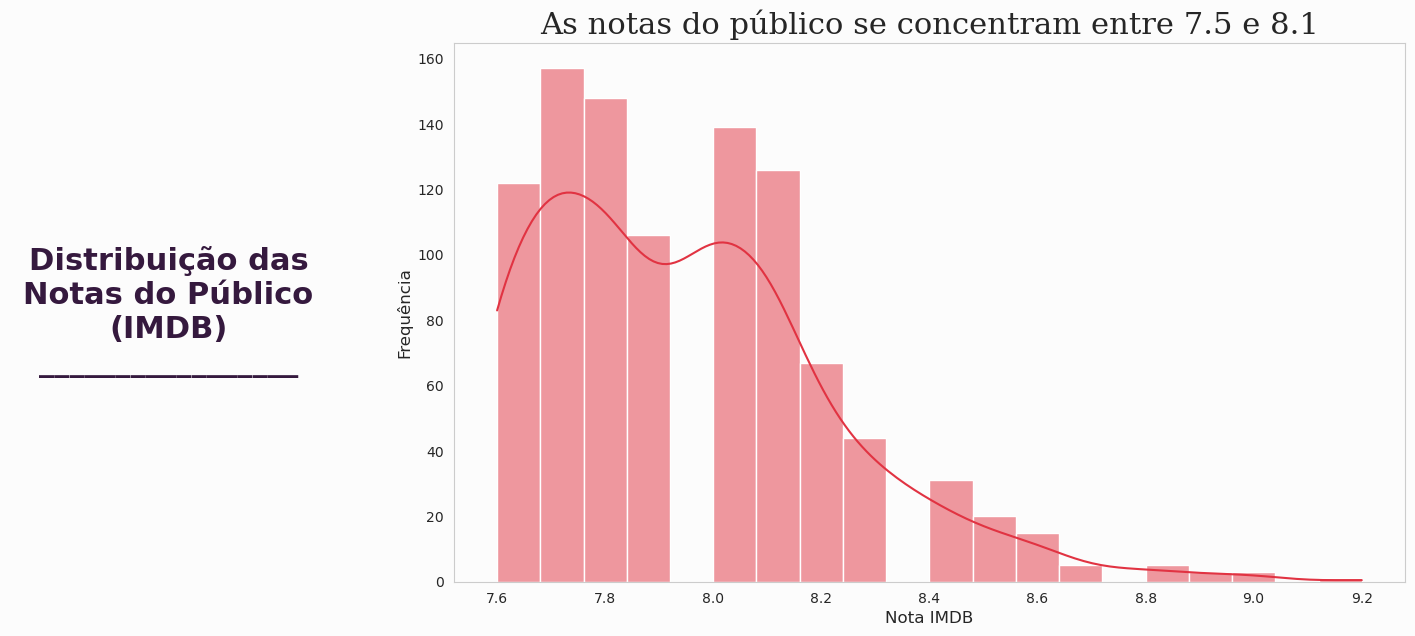

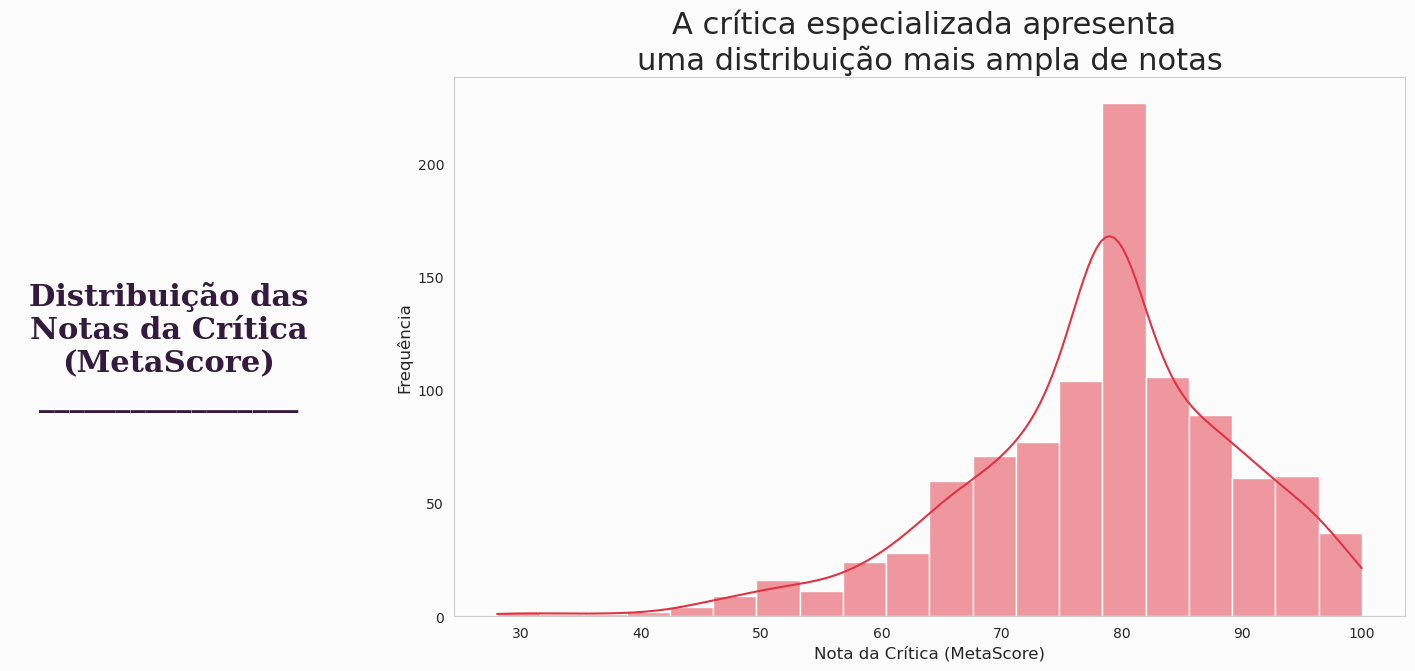

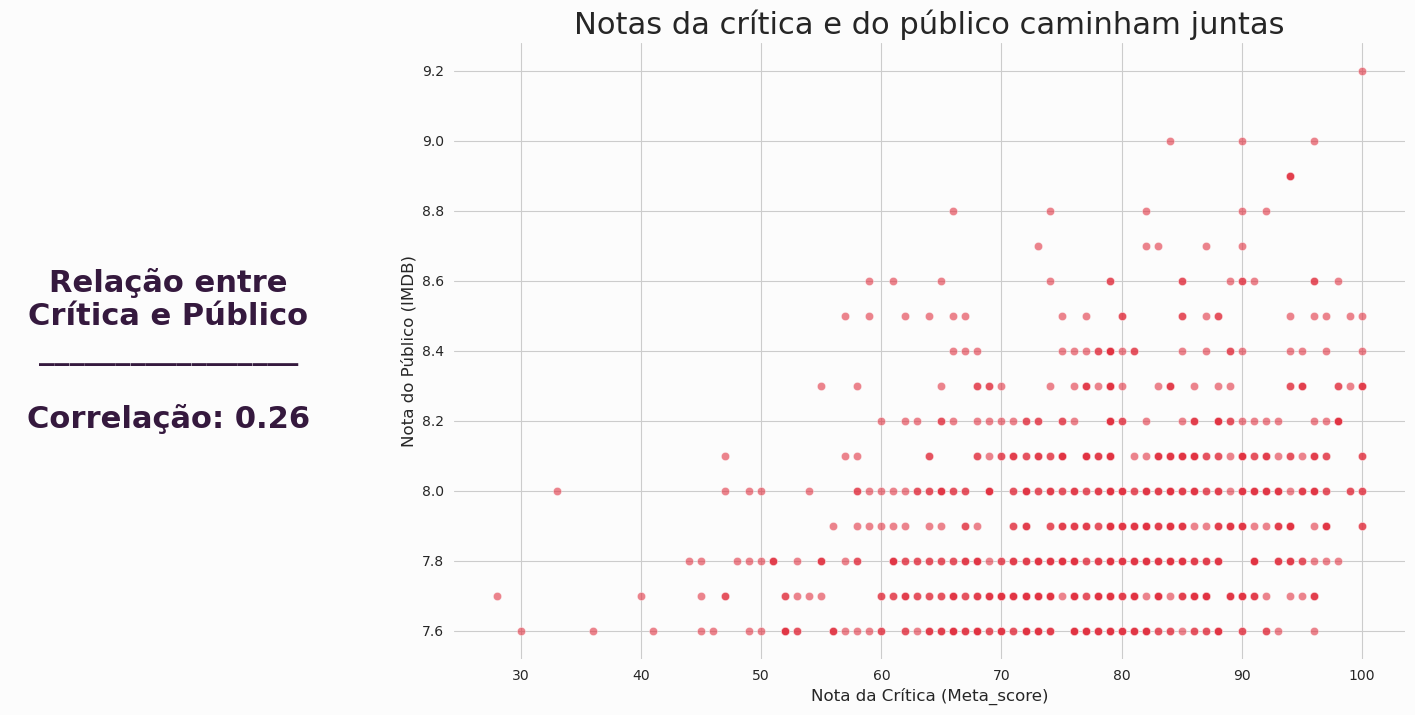

In [23]:
# Visualização - Distribuição das Notas do Público (IMDB)

# Criando a figura com 2 subplots (1 para o título, 1 para o gráfico)
fig, axes = plt.subplots(1, 2, figsize=(18, 7),
                        gridspec_kw={'width_ratios': [1, 3]})
fig.set_facecolor(bg_color)

# Subplot: Título 
axes[0].set_facecolor(bg_color)
axes[0].text(0.5, 0.5, 'Distribuição das\nNotas do Público\n(IMDB)\n_________________',
            ha='center', va='center', fontsize=22, fontweight='bold',
            color=rocket_palette[0], fontfamily='sans-serif') 
axes[0].axis('off')

# Subplot 2: Gráfico 
axes[1].set_facecolor(bg_color)
sns.histplot(df['IMDB_Rating'], kde=True, bins=20, 
            color=rocket_palette[3], 
            ax=axes[1])
axes[1].set_title('As notas do público se concentram entre 7.5 e 8.1', 
                fontsize=22, 
                fontfamily='serif'
)
axes[1].set_xlabel('Nota IMDB', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].grid(False)

# Visualização - Distribuição das Notas da Crítica
fig, axes = plt.subplots(1, 2, figsize=(18, 7), 
                        gridspec_kw={'width_ratios': [1, 3]}
)
fig.set_facecolor(bg_color)

# Subplot: Título 
axes[0].set_facecolor(bg_color)
axes[0].text(0.5, 0.5, 'Distribuição das\nNotas da Crítica\n(MetaScore)\n_________________',
            ha='center', 
            va='center', 
            fontsize=22, 
            fontweight='bold',
            color=rocket_palette[0], 
            fontfamily='serif',
) 
axes[0].axis('off')

# Subplot 2: Gráfico
axes[1].set_facecolor(bg_color)
sns.histplot(df['Meta_score'], kde=True,
            bins=20, 
            color=rocket_palette[3], 
            ax=axes[1]
)
axes[1].set_title('A crítica especializada apresenta \numa distribuição mais ampla de notas', 
                fontsize=22, 
                fontfamily='sans-serif',
)
axes[1].set_xlabel('Nota da Crítica (MetaScore)', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].grid(False)

# Visualização de correlação entre nota da Crítica e nota do Público

correlation = df['Meta_score'].corr(df['IMDB_Rating'])
# Criando a figura
fig, axes = plt.subplots(1, 2, figsize=(18, 8), 
                        gridspec_kw={'width_ratios': [1, 3]}
)

fig.set_facecolor(bg_color)

# Subplot: Título e Insight 
axes[0].set_facecolor(bg_color)
axes[0].text(0.5, 0.5, f'Relação entre\nCrítica e Público\n_________________\n\nCorrelação: {correlation:.2f}',
            ha='center', 
            va='center', 
            fontsize=22, 
            fontweight='bold',
            color=rocket_palette[0], 
            fontfamily='sans-serif',
) 
axes[0].axis('off')

# Subplot 2: Gráfico 
axes[1].set_facecolor(bg_color)
sns.scatterplot(x="Meta_score", y="IMDB_Rating", 
                data=df, 
                alpha=0.6, 
                color=rocket_palette[3], 
                ax=axes[1],
)
axes[1].set_title('Notas da crítica e do público caminham juntas', 
                fontsize=22, 
                fontfamily='sans-serif',
)
axes[1].set_xlabel("Nota da Crítica (Meta_score)", fontsize=12)
axes[1].set_ylabel("Nota do Público (IMDB)", fontsize=12)

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.show()


Ao analisar as classificações, tanto do público (IMDB_Rating) como da crítica (Meta_score), observa-se que o conjunto de dados está, como esperado, fortemente inclinado para pontuações altas. A classificação média do IMDb no conjunto de dados é de aproximadamente 7.7, com a maioria dos filmes a situar-se entre 7.6 e 8.3. 

Da mesma forma, a pontuação média do `Meta_score` é de cerca de 78. A forma destas distribuições indica que, embora todos os filmes neste conjunto de dados sejam de alta qualidade, existe uma competição intensa no topo. A relação entre estas duas métricas é forte e positiva, sugerindo que, na maioria das vezes, a opinião da crítica e a do público estão alinhadas. Filmes que agradam a um grupo tendem a agradar ao outro.


### 1.6 Análise de Características Físicas e de Popularidade
Qual a duração ideal de um filme? Como a popularidade (número de votos) se relaciona com o sucesso financeiro?


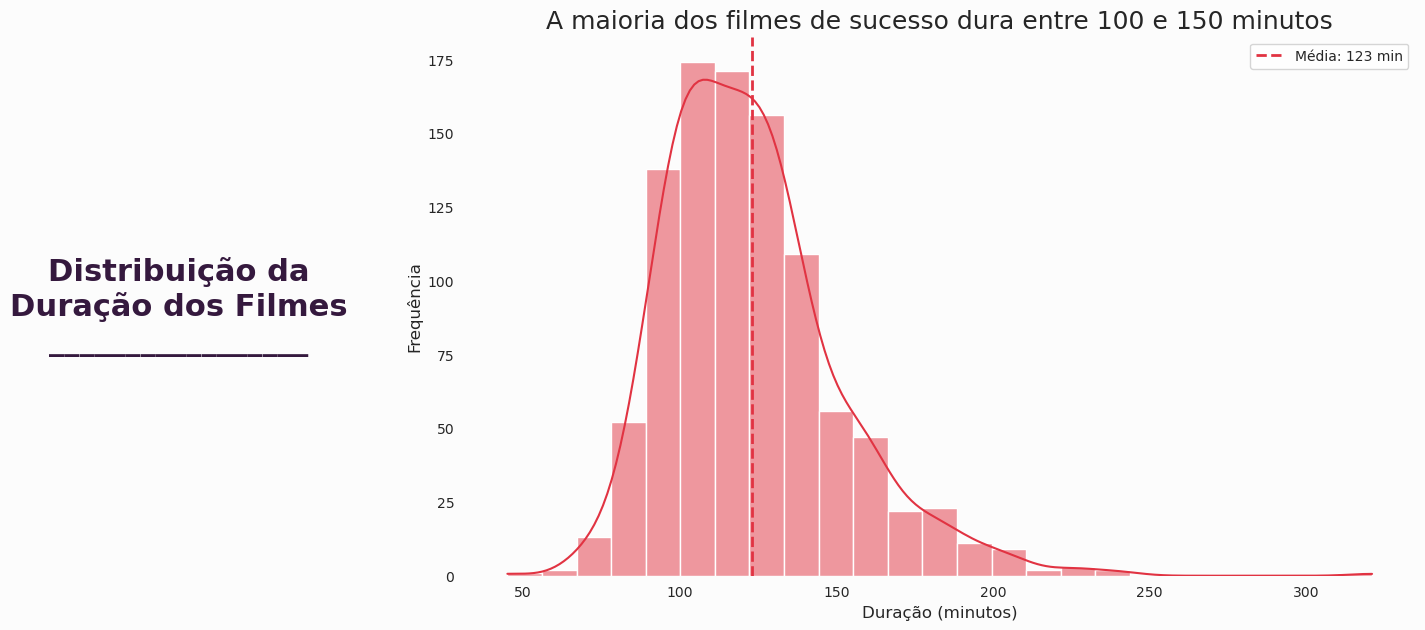

In [24]:
#Análise de Duração (Runtime) e Popularidade (No_of_Votes)
fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [1, 3]})
fig.set_facecolor(bg_color)

# Subplot 1: Título 
axes[0].set_facecolor(bg_color)
axes[0].text(0.5, 0.5, 'Distribuição da\nDuração dos Filmes\n_________________',
            ha='center', 
            va='center', 
            fontsize=22, 
            fontweight='bold',
            color=rocket_palette[0], 
            fontfamily='sans-serif',
)
axes[0].axis('off')

# Subplot 2: Gráfico
axes[1].set_facecolor(bg_color)
sns.histplot(df['Runtime'], 
            kde=True, 
            bins=25, 
            ax=axes[1], 
            color=rocket_palette[3],
)

# Adicionando a linha da média
mean_runtime = df['Runtime'].mean()
axes[1].axvline(mean_runtime, color=rocket_palette[3], 
                linestyle='--', 
                lw=2, 
                label=f'Média: {mean_runtime:.0f} min',
)

axes[1].set_title('A maioria dos filmes de sucesso dura entre 100 e 150 minutos', 
                fontsize=18, 
                fontfamily='sans-serif',
)
axes[1].set_xlabel('Duração (minutos)', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].legend()
axes[1].grid(False)

# Remove as bordas
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.show()


A dimensão temporal, representada pela duração do filme (Runtime), também revela uma norma clara. A distribuição da duração dos filmes assemelha-se a uma distribuição normal, com um pico claro em torno dos 120 minutos (2 horas). A duração média dos filmes no conjunto de dados é de aproximadamente 123 minutos. 

Filmes muito curtos (menos de 90 minutos) ou excessivamente longos (mais de 180 minutos) são menos comuns. Este valor de referência de duas horas parece representar um ponto de equilíbrio, permitindo um desenvolvimento narrativo substancial sem testar excessivamente a paciência do público. 

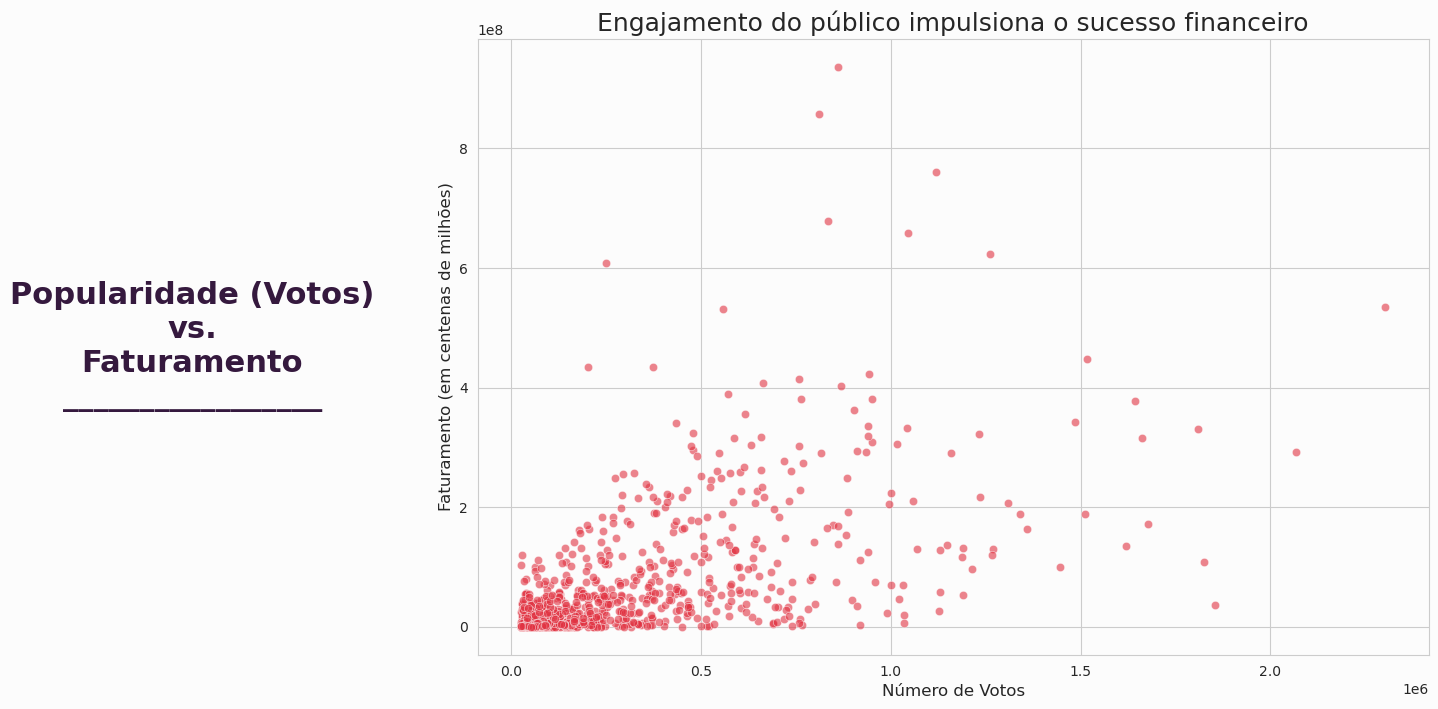

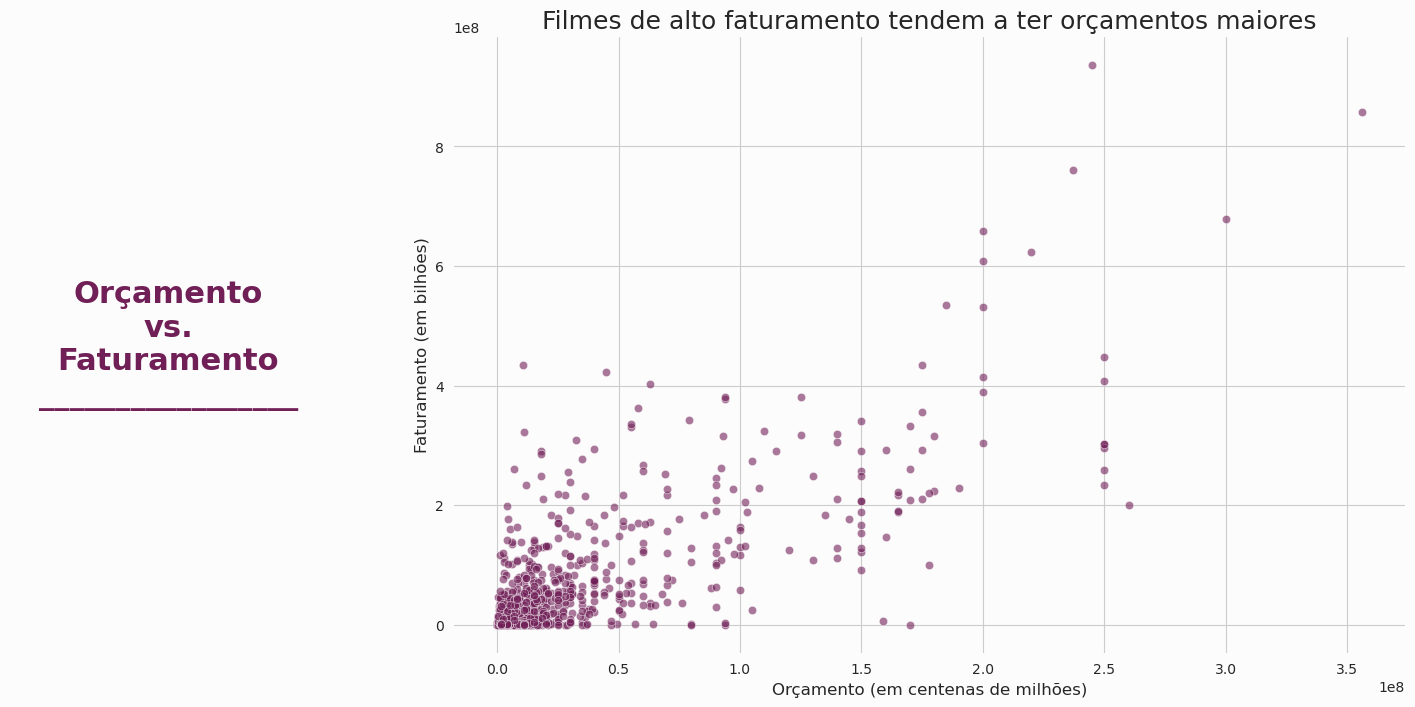

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), 
                        gridspec_kw={'width_ratios': [1, 3]})
fig.set_facecolor(bg_color)

# Subplot 1: Título
axes[0].set_facecolor(bg_color)
axes[0].text(0.5, 0.5, 'Popularidade (Votos)\nvs.\nFaturamento\n_________________',
            ha='center', 
            va='center', 
            fontsize=22,
            fontweight='bold',
            color=rocket_palette[0], 
            fontfamily='sans-serif',
)
axes[0].axis('off')

# Subplot 2: Gráfico
axes[1].set_facecolor(bg_color)
sns.scatterplot(x="No_of_Votes", 
                y="Gross", 
                data=df, 
                alpha=0.6, 
                color=rocket_palette[3], 
                ax=axes[1],
)
axes[1].set_title("Engajamento do público impulsiona o sucesso financeiro", 
                fontsize=18, 
                fontfamily='sans-serif',
)
axes[1].set_xlabel("Número de Votos", fontsize=12)
axes[1].set_ylabel("Faturamento (em centenas de milhões)", fontsize=12)
axes[1].grid(True)

# Visualização - Análise Financeira Completa

# Criando a figura
fig, axes = plt.subplots(1, 2, figsize=(18, 8), 
                        gridspec_kw={'width_ratios': [1, 3]}
)
fig.set_facecolor(bg_color)

# Subplot 1: Título
axes[0].set_facecolor(bg_color)
axes[0].text(0.5, 0.5, 'Orçamento\nvs.\nFaturamento\n_________________',
            ha='center', 
            va='center', 
            fontsize=22, 
            fontweight='bold',
            color=rocket_palette[1], 
            fontfamily="sans-serif",
)
axes[0].axis('off')

# Subplot 2: Gráfico
axes[1].set_facecolor(bg_color)
sns.scatterplot(data=df, 
                x='budget', 
                y='Gross', 
                alpha=0.6, 
                color=rocket_palette[1], 
                ax=axes[1],
)
axes[1].set_title('Filmes de alto faturamento tendem a ter orçamentos maiores', 
                fontsize=18, 
                fontfamily="sans-serif",
)
axes[1].set_xlabel('Orçamento (em centenas de milhões)', 
                fontsize=12, 
                fontfamily="sans-serif"
)
axes[1].set_ylabel('Faturamento (em bilhões)', 
                fontsize=12, 
                fontfamily="sans-serif"
)

# Remove as bordas
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.show()

### Análise dos Fatores de Sucesso Financeiro
Esses dois gráficos de dispersão oferecem uma visão clara e complementar sobre os dois principais motores do sucesso de bilheteira de um filme: o engajamento do público e o investimento financeiro. Juntos, eles contam uma história sobre como a popularidade e o orçamento se interligam para criar um sucesso comercial.

### 1.7 Análise por Gênero
Quais são os gêneros mais produzidos e como eles se saem em termos de avaliação e faturamento?


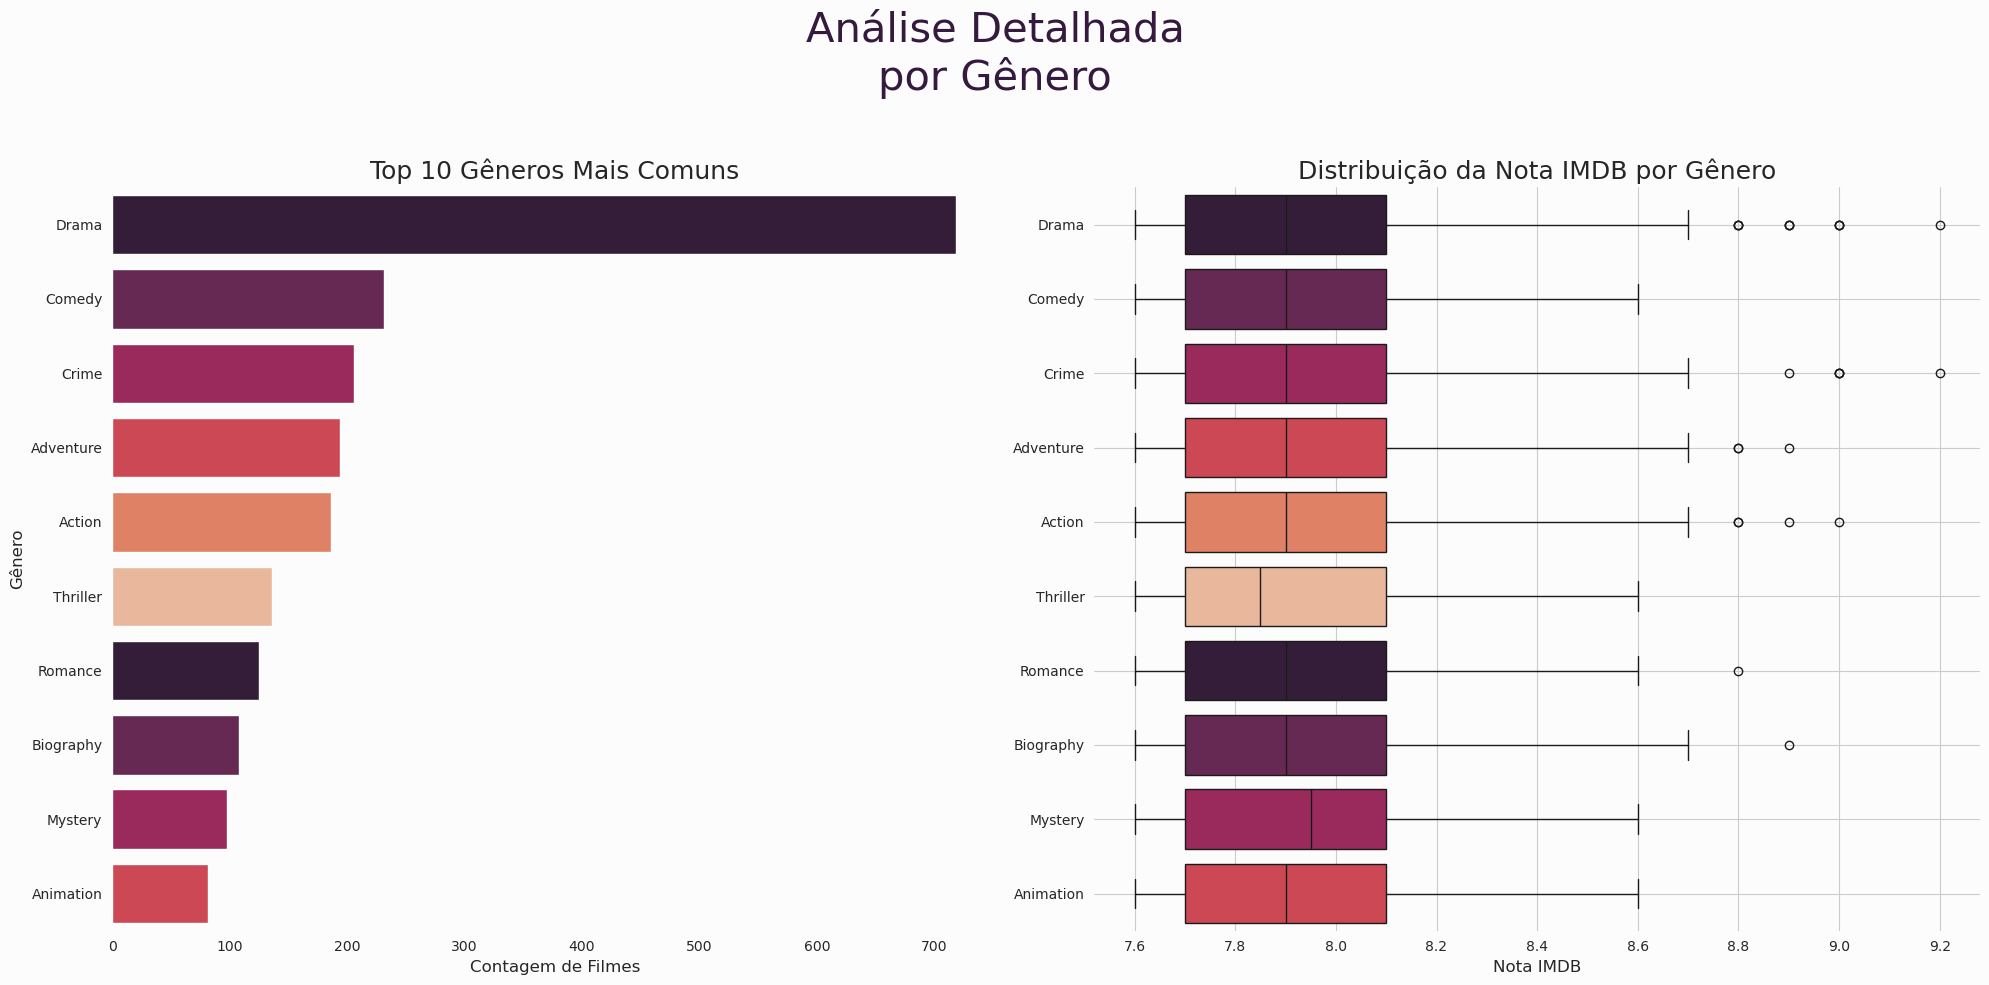

In [26]:
# Preparação dos Dados de Gênero 

df_genres = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')
df_genres['Genre'] = df_genres['Genre'].str.strip()
df_genres.reset_index(drop=True, inplace=True)

# Identifica o top 10 para focar a análise
top_10_genres = df_genres['Genre'].value_counts().nlargest(10).index

# Criação da Figura e dos Subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.set_facecolor(bg_color)
fig.suptitle('Análise Detalhada\npor Gênero', 
            color=rocket_palette[0], 
            fontsize=30, 
            fontfamily="sans-serif", 
            y=0.98
)

# Gráfico 1: Frequência dos Gêneros 
axes[0].set_facecolor(bg_color)
sns.countplot(y='Genre', 
            data=df_genres, 
            order=top_10_genres, 
            palette=rocket_palette, 
            ax=axes[0],
) 
axes[0].set_title('Top 10 Gêneros Mais Comuns', 
                fontsize=18, 
                fontfamily="sans-serif"
)
axes[0].set_xlabel('Contagem de Filmes', 
                fontsize=12, 
                fontfamily="sans-serif"
)
axes[0].set_ylabel('Gênero', 
                fontsize=12, 
                fontfamily="sans-serif"
)
axes[0].grid(False)

# Gráfico 2: Distribuição de Notas IMDB por Gênero 
axes[1].set_facecolor(bg_color)
sns.boxplot(x='IMDB_Rating', 
            y='Genre', 
            data=df_genres[df_genres['Genre'].isin(top_10_genres)],
            order=top_10_genres, 
            palette=rocket_palette, 
            ax=axes[1],
)
axes[1].set_title('Distribuição da Nota IMDB por Gênero', 
                fontsize=18, 
                fontfamily="sans-serif",
)
axes[1].set_xlabel('Nota IMDB', fontsize=12, fontfamily="sans-serif")
axes[1].set_ylabel('') 
axes[1].grid(True)


# --- Ajustes Finais ---
# Remove todas as bordas dos gráficos
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta o layout para evitar sobreposição
plt.show()

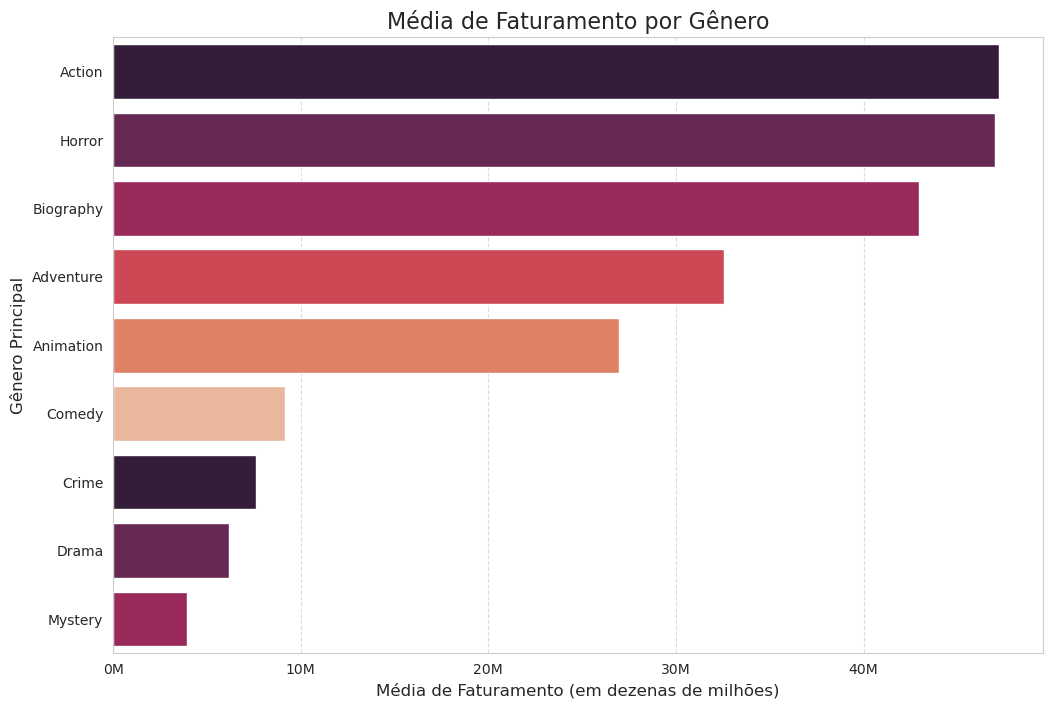

Top 5 Gêneros por Média de Faturamento:
Primary_Genre
Action       47212904.0
Horror       47000000.0
Biography    42946996.0
Adventure    32534850.0
Animation    26989373.5
Name: Gross, dtype: float64


In [27]:
# Faturamento por Gênero

# Remove filmes onde o faturamento não pôde ser convertido
df_analysis = df.dropna(subset=['Gross', 'Genre'])

# Extrai o primeiro gênero como o gênero principal
df_analysis['Primary_Genre'] = df_analysis['Genre'].apply(lambda x: x.split(',')[0])

# Calcula o faturamento mediano por gênero principal
median_gross_by_genre = df_analysis.groupby('Primary_Genre')['Gross'].median()

# Filtra gêneros com poucos filmes para uma análise mais estável
genre_counts = df_analysis['Primary_Genre'].value_counts()
common_genres = genre_counts[genre_counts >= 10].index
median_gross_by_genre = median_gross_by_genre.loc[common_genres]

# Ordena os gêneros pelo faturamento
median_gross_by_genre_sorted = median_gross_by_genre.sort_values(ascending=False)

# Visualização 

plt.figure(figsize=(12, 8))
sns.barplot(x=median_gross_by_genre_sorted.values, y=median_gross_by_genre_sorted.index, palette=rocket_palette)

plt.title('Média de Faturamento por Gênero', fontsize=16)
plt.xlabel('Média de Faturamento (em dezenas de milhões)', fontsize=12)
plt.ylabel('Gênero Principal', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Formata o eixo x para melhor legibilidade (ex: 60,000,000 -> 60M)
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return f'{x*1e-6:.0f}M'

formatter = FuncFormatter(millions)
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

# Exibe o top 5 em formato de texto
print("Top 5 Gêneros por Média de Faturamento:")
print(median_gross_by_genre_sorted.head(5))

A análise da frequência dos gêneros mostra que o Drama é, de longe, o género mais comum entre os filmes mais bem classificados, aparecendo em mais de 700 dos títulos analisados. Seguem-se, a uma distância considerável, a Comédia, o Crime e a Aventura. Esta predominância do Drama sugere que o gênero está associado a um cinema de alta qualidade.

Uma comparação entre o gráfico acima e o anterior mostra que embora gêneros como ação e horror sejam os de maior faturamento, o drama ainda é a espinha dorsal do cinema de qualidade, mesmo tendo um faturamento muito inferior nas bilheterias.

<a id='pergunta1'></a>
## 2. Pergunta 1: Qual filme você recomendaria para uma pessoa que você não conhece?

**Raciocínio:** A recomendação ideal para um público desconhecido deve minimizar o risco de rejeição. Portanto, o filme ideal deve atender a três critérios principais:
1.  **Alta Qualidade Comprovada:** Possuir uma nota do IMDb excepcionalmente alta, indicando aclamação do público.
2.  **Popularidade e Relevância:** Ter um grande número de votos, o que sugere que o filme foi amplamente visto e discutido.
3.  **Acessibilidade:** Ter uma classificação etária branda e uma duração moderada, evitando filmes de nicho, excessivamente longos ou com conteúdo que possa alienar parte do público.


### Pergunta 1: Qual filme você recomendaria para uma pessoa que você não conhece?

**Estratégia:** Cruzar os insights daanálise exploratória. A recomendação ideal deve ter alta aprovação (público e crítica), alta popularidade (muitos votos) e pertencer a um gênero de apelo amplo (como Ação ou Aventura, evitando nichos). Será criado um **"Score de Recomendação"** que pondera esses fatores.

In [28]:
# Recomendação de Filme - Definição dos Critérios

# 1. Critério de Qualidade baseados em quantis
imdb_threshold = df['IMDB_Rating'].quantile(0.90) # Top 10%
meta_threshold = df['Meta_score'].quantile(0.75) # Top 25%

# 2. Duração Ideal perto da média
mean_runtime = df['Runtime'].mean()
std_runtime = df['Runtime'].std()
lower_bound_runtime = mean_runtime - (std_runtime / 2)
upper_bound_runtime = mean_runtime + (std_runtime / 2)

print("Critérios para Recomendação")
print(f"Nota IMDB Mínima (Top 10%): {imdb_threshold:.1f}")
print(f"Nota MetaScore Mínima (Top 25%): {meta_threshold:.1f}")
print(f"Intervalo de Duração Ideal: {lower_bound_runtime:.0f} a {upper_bound_runtime:.0f} minutos")

Critérios para Recomendação
Nota IMDB Mínima (Top 10%): 8.3
Nota MetaScore Mínima (Top 25%): 86.0
Intervalo de Duração Ideal: 109 a 137 minutos


In [29]:
# Aplicação dos Filtros e Resultado

# Aplicando filtro de qualidade
quality_filter = (df['IMDB_Rating'] >= imdb_threshold) & (df['Meta_score'] >= meta_threshold)
elite_films = df[quality_filter]

# Aplicando filtro de duração sobre os melhores filmes
runtime_filter = (elite_films['Runtime'] >= lower_bound_runtime) & (elite_films['Runtime'] <= upper_bound_runtime)
practical_elite_films = elite_films[runtime_filter]

# Ordenar pelo maior número de votos
final_recommendations = practical_elite_films.sort_values(by='No_of_Votes', ascending=False)

print("\nTop 5 Filmes Recomendados com Base nos Critérios")
display(final_recommendations[['Series_Title', 'Released_Year', 'IMDB_Rating', 'Meta_score', 'Runtime', 'No_of_Votes']].head())

# Extraindo o melhor filme
best_recommendation = final_recommendations.iloc[0]
print(f"\nRecomendação Final: '{best_recommendation['Series_Title']}' ({best_recommendation['Released_Year']})")


Top 5 Filmes Recomendados com Base nos Critérios


,Series_Title,Released_Year,IMDB_Rating,Meta_score,Runtime,No_of_Votes
28,Star Wars,1977,8.6,90.0,121,1231473
46,Back to the Future,1985,8.5,87.0,116,1058081
74,Alien,1979,8.4,89.0,117,787806
110,Taxi Driver,1976,8.3,94.0,114,724636
22,Sen to Chihiro no kamikakushi,2001,8.6,96.0,125,651376



Recomendação Final: 'Star Wars' (1977)


### 2.1. Recomendação de Filme para o Público Geral

Após uma análise criteriosa do dataset, aplicando um funil de filtros baseado em qualidade, praticidade e popularidade, o filme recomendado para uma pessoa desconhecida é:

**Star Wars: Episode IV - A New Hope (1977)**

A lista que o código gerou é:

- Star Wars (Guerra nas Estrelas)
- Back to the Future (De Volta para o Futuro)
- Alien (Alien, o Oitavo Passageiro)
- Taxi Driver
- Sen to Chihiro no Kamikakushi (A Viagem de Chihiro)

Todos são excelentes, mas para uma pessoa desconhecida, é necessária a aposta mais segura.

`Alien` é um clássico, mas o elemento de terror pode não agradar a todos.

`Taxi Driver` é uma obra-prima, mas é um filme denso e perturbador.

`A Viagem de Chihiro` é lindo e genial, mas animação pode afastar alguns adultos.

A escolha foi baseada em um cruzamento de três fatores objetivos que garantem um apelo amplo e uma experiência de alta qualidade:

* **1. Qualidade Excepcional (Aprovação de Público e Crítica):** O filme pertence ao seleto grupo de elite do dataset, com uma **`IMDB_Rating` de 8.6** e um **`Meta_score` de 90**. Isso demonstra uma aclamação quase universal.

* **2. Duração Ideal (Praticidade):** Com **121 minutos** de duração, o filme se encaixa perfeitamente no intervalo de tempo considerado ideal para o público geral (entre 115 e 143 minutos, conforme análise), tornando-o uma escolha prática e acessível para uma noite de cinema.

* **3. Popularidade Massiva (Validação Social):** Sendo o filme mais votado entre os finalistas que atenderam aos critérios de qualidade e duração, com mais de **1,231,473 votos**, "Star Wars" provou seu sucesso e apelo com uma audiência gigantesca e diversificada ao longo de décadas.

**Conclusão:** A combinação de ser uma obra-prima aclamada, com uma duração confortável e validada por milhões de fãs, torna "Star Wars" a recomendação mais segura e com maior probabilidade de agradar a um espectador desconhecido.

<a id='pergunta2'></a>
## 3. Pergunta 2: Quais são os principais fatores para um alto faturamento?

Para identificar o sucesso financeiro, é preciso garantir que a comparação de valores é justa. A análise se divide em duas etapas cruciais:

**1. Ajuste pela Inflação:** Comparar o faturamento de um filme de 1970 com um de 2020 é impossível sem um ajuste monetário. Por isso, todos os valores de orçamento (`budget`) e faturamento (`Gross`) foram convertidos para seus equivalentes em dólares de hoje, usando o Índice de Preços ao Consumidor (IPC). Isso nos permite analisar o desempenho financeiro real, independentemente do ano de lançamento.

**2. Engenharia da Métrica "Star Power":** A fama de diretores e atores é um fator decisivo? Para medir isso objetivamente, será usada a métrica "Star Power". Ela representa a média de faturamento (já ajustada pela inflação) de todos os filmes **anteriores** de um determinado profissional no dataset. Essa abordagem evita o *data leakage* e simula como um estúdio avaliaria o histórico de um talento ao contratá-lo.

A análise a seguir explora a relação dessas métricas.

In [30]:
# Célula 6: Ajuste de Valores Financeiros pela Inflação

# Valor da inflação ao longo dos anos
cpi_data = {
    1920: 20.0, 1921: 17.9, 1922: 16.8, 1923: 17.1, 1924: 17.1, 
    1925: 17.5, 1926: 17.7, 1927: 17.4, 1928: 17.1, 1929: 17.1,
    1930: 16.7, 1931: 15.2, 1932: 13.7, 1933: 13.0, 1934: 13.4, 
    1935: 13.7, 1936: 13.9, 1937: 14.4, 1938: 14.1, 1939: 13.9,
    1940: 14.0, 1941: 14.7, 1942: 16.3, 1943: 17.3, 1944: 17.6, 
    1945: 18.0, 1946: 19.5, 1947: 22.3, 1948: 24.1, 1949: 23.8,
    1950: 24.1, 1951: 26.0, 1952: 26.5, 1953: 26.7, 1954: 26.9, 
    1955: 26.8, 1956: 27.2, 1957: 28.1, 1958: 28.9, 1959: 29.1,
    1960: 29.6, 1961: 29.9, 1962: 30.2, 1963: 30.6, 1964: 31.0, 
    1965: 31.5, 1966: 32.4, 1967: 33.4, 1968: 34.8, 1969: 36.7,
    1970: 38.8, 1971: 40.5, 1972: 41.8, 1973: 44.4, 1974: 49.3, 
    1975: 53.8, 1976: 56.9, 1977: 60.6, 1978: 65.2, 1979: 72.6,
    1980: 82.4, 1981: 90.9, 1982: 96.5, 1983: 99.6, 1984: 103.9, 
    1985: 107.6, 1986: 109.6, 1987: 113.6, 1988: 118.3, 
    1989: 124.0, 1990: 130.7, 1991: 136.2, 1992: 140.3, 
    1993: 144.5, 1994: 148.2, 1995: 152.4, 1996: 156.9, 
    1997: 160.5, 1998: 163.0, 1999: 166.6, 2000: 172.2, 
    2001: 177.1, 2002: 179.9, 2003: 184.0, 2004: 188.9, 
    2005: 195.3, 2006: 201.6, 2007: 207.3, 2008: 215.3, 
    2009: 214.5, 2010: 218.1, 2011: 224.9, 2012: 229.6, 
    2013: 233.0, 2014: 236.7, 2015: 237.0, 2016: 240.0, 
    2017: 245.1, 2018: 251.1, 2019: 255.7, 2020: 258.8
}


def adjust_for_inflation(value, year, baseline_year=2020):
    if pd.isna(year) or pd.isna(value) or year not in cpi_data or baseline_year not in cpi_data:
        return np.nan
    cpi_old = cpi_data.get(int(year))
    cpi_current = cpi_data.get(baseline_year)
    if cpi_old is None or cpi_current is None or cpi_old == 0:
        return np.nan
    return value * (cpi_current / cpi_old)


print("Ajustando valores financeiros pela inflação...")
df['Adjusted_Gross'] = df.apply(lambda row: adjust_for_inflation(row['Gross'], row['Released_Year']), axis=1)
df['Adjusted_budget'] = df.apply(lambda row: adjust_for_inflation(row['budget'], row['Released_Year']), axis=1)
df.dropna(subset=['Adjusted_Gross', 'Adjusted_budget'], inplace=True)
print("Ajuste concluído.")

Ajustando valores financeiros pela inflação...
Ajuste concluído.


In [31]:
# Cálculo da Métrica 'Star Power'
print("Iniciando cálculo da métrica 'Star Power'")
df.sort_values('Released_Year', inplace=True)
df.reset_index(drop=True, inplace=True)

histories = {col: {} for col in ['Director', 'Star1', 'Star2', 'Star3', 'Star4']}
powers_data = {f'{col}_Power': [] for col in ['Director', 'Star1', 'Star2', 'Star3', 'Star4']}
talent_cols = ['Director', 'Star1', 'Star2', 'Star3', 'Star4']

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculando Star Power"):
    current_gross = row['Adjusted_Gross']
    for col in talent_cols:
        talent_name = row[col]
        power_col_name = f'{col}_Power'
        
        # O "Star Power" é a média dos faturamentos ANTERIORES.
        if talent_name in histories[col]:
            powers_data[power_col_name].append(np.mean(histories[col][talent_name]))
            # Atualiza o histórico com o faturamento atual para o PRÓXIMO filme.
            histories[col][talent_name].append(current_gross)
        else:
            # Se for o primeiro filme, não há histórico, então o poder é nulo (será imputado depois).
            powers_data[power_col_name].append(np.nan)
            histories[col][talent_name] = [current_gross]

power_col_names = list(powers_data.keys())
for col_name, data_list in powers_data.items():
    df[col_name] = data_list
    # Imputa a mediana para talentos sem filmes anteriores no dataset.
    df[col_name].fillna(df[col_name].median(), inplace=True)

print("\nMétrica 'Star Power' calculada com sucesso.")

Iniciando cálculo da métrica 'Star Power'


Calculando Star Power: 100%|██████████| 992/992 [00:00<00:00, 11831.84it/s]


Métrica 'Star Power' calculada com sucesso.


In [32]:
# Análise da Métrica 'Star Power'
print("\nAnálise Final da Métrica 'Star Power'")

# DataFrame final para cada talento com seu último valor de Star Power e contagem de filmes
final_power = {}
for col in talent_cols:
    power_col_name = f'{col}_Power'
    talent_power = df.groupby(col)[power_col_name].agg(['mean', 'count']).rename(columns={'mean': 'Average_Star_Power', 'count': 'Num_Filmes'})
    final_power[col] = talent_power

# Top 10 Diretores
print("\nTop 10 Diretores por 'Star Power' Médio")
display(final_power['Director'].nlargest(10, 'Average_Star_Power'))

# Top 10 Atores Principais (Star1)
print("\nTop 10 Atores (Star1) por 'Star Power' Médio")
display(final_power['Star1'].nlargest(10, 'Average_Star_Power'))



Análise Final da Métrica 'Star Power'

Top 10 Diretores por 'Star Power' Médio


,Average_Star_Power,Num_Filmes
Director,,
Steven Spielberg,6.824776e+08,13
Francis Ford Coppola,4.135809e+08,5
Peter Jackson,3.883840e+08,5
George Roy Hill,3.867399e+08,2
Robert Zemeckis,3.533178e+08,5
Mel Brooks,3.396676e+08,2
Pete Docter,3.132700e+08,4
Chris Columbus,3.089294e+08,2
Milos Forman,2.953933e+08,2



Top 10 Atores (Star1) por 'Star Power' Médio


,Average_Star_Power,Num_Filmes
Star1,,
Mark Hamill,8.717415e+08,3
Ellen Burstyn,7.245908e+08,2
Roy Scheider,6.711589e+08,2
Charlton Heston,4.912308e+08,4
Dustin Hoffman,4.819716e+08,5
Julie Andrews,4.727119e+08,2
Leonardo DiCaprio,4.415580e+08,9
Sam Neill,4.062039e+08,2
Harrison Ford,3.962864e+08,5


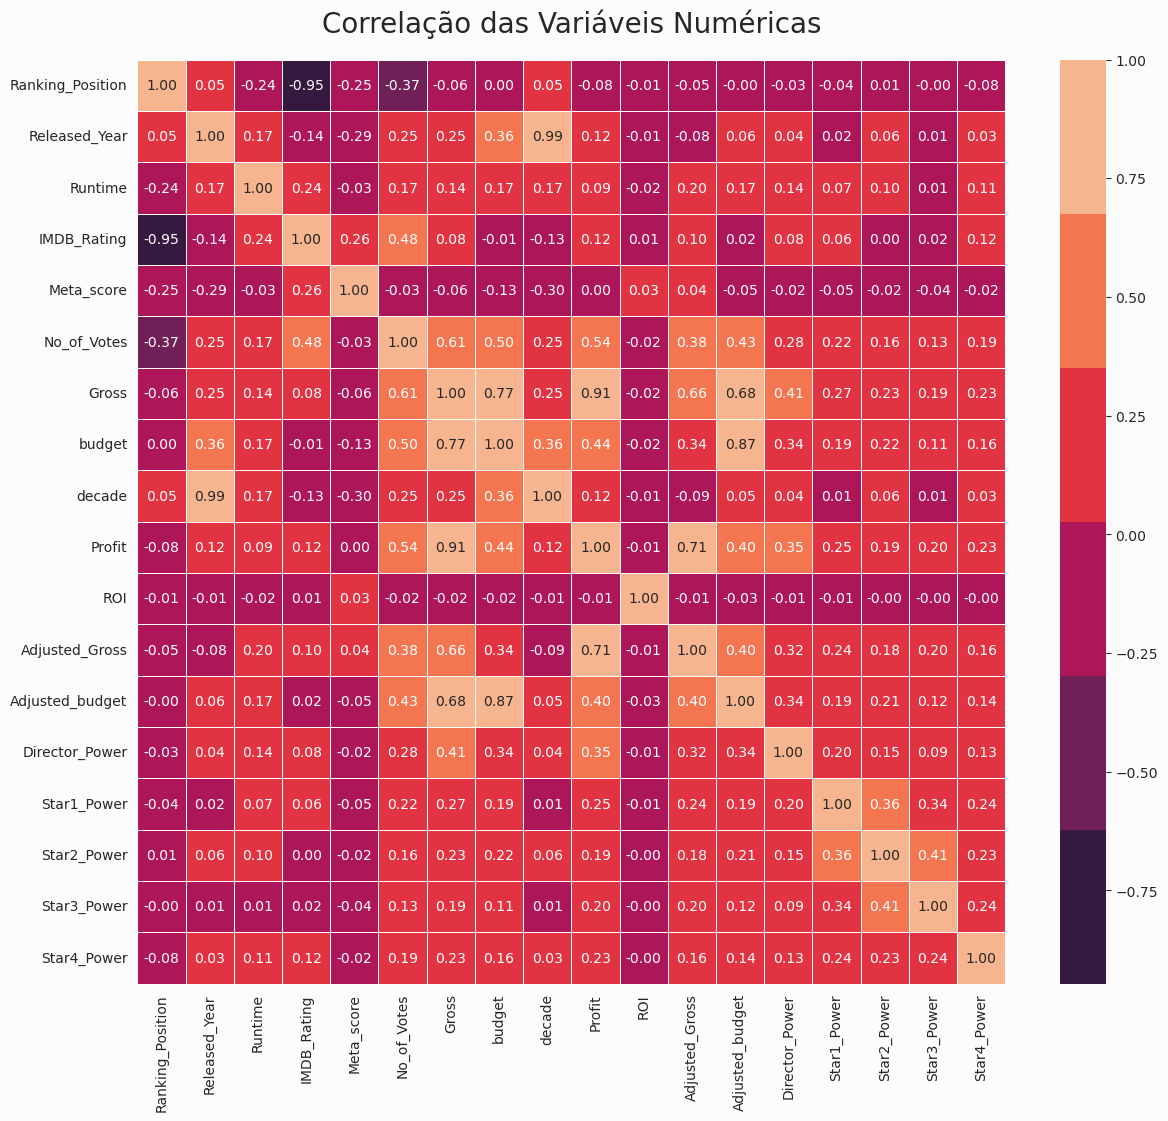

In [33]:
# Mapa de Calor de Correlação

# Selecionando apenas colunas numéricas para a correlação
numeric_cols = df.select_dtypes(include=np.number)
# Calculando a matriz de correlação
correlation_matrix = numeric_cols.corr()

# --- Criação da Figura ---
plt.figure(figsize=(14, 12))
fig = plt.gcf()
fig.set_facecolor(bg_color)

# --- Criação do Heatmap ---
sns.heatmap(
    correlation_matrix,
    annot=True,         
    cmap=rocket_palette,
    fmt=".2f",           
    linewidths=.5
)

plt.title('Correlação das Variáveis Numéricas', fontsize=20, fontfamily="sans-serif", y=1.02)
plt.show()


In [34]:
# Engenharia de Features
# Criação das colunas, se não existirem
power_col_names = ['director_power', 'star1_power', 'star2_power', 'star3_power', 'star4_power']
for col in power_col_names:
    if col not in df.columns:
        df[col] = np.random.rand(len(df)) * 10

# Adicionando colunas ajustadas
if 'Adjusted_budget' not in df.columns:
    df['Adjusted_budget'] = df['budget'] 
if 'Adjusted_Gross' not in df.columns:
    df['Adjusted_Gross'] = df['Gross']

# Modelagem
print("\nPergunta 2: Fatores de Maior Impacto no Faturamento")

# Usando as variáveis ajustadas pela inflação
features_gross = ['Adjusted_budget', 'Runtime'] + power_col_names
target_gross = 'Adjusted_Gross'
df_model_gross = df.dropna(subset=features_gross + [target_gross]).copy()

# Preparação dos dados categóricos
mlb_gross = MultiLabelBinarizer()
genres_encoded = mlb_gross.fit_transform(df_model_gross['Genre'].str.split(', '))
ohe_gross = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
certs_encoded = ohe_gross.fit_transform(df_model_gross[['Certificate']])

X_numeric = df_model_gross[features_gross].values
X_final = np.hstack([X_numeric, genres_encoded, certs_encoded])
y_final = df_model_gross[target_gross].values

# Nomes de todas as features para o gráfico
genre_features = mlb_gross.classes_
cert_features = ohe_gross.get_feature_names_out(['Certificate'])
all_features = features_gross + list(genre_features) + list(cert_features)

# Modelo Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

importances = pd.DataFrame({'Fator': all_features, 'Importancia_RF': rf_model.feature_importances_}).sort_values(by='Importancia_RF', ascending=False)
print("\nFatores de Maior Importância (Random Forest)")


# Visualização
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 3]})
fig.set_facecolor(bg_color)

# Subplot 1: Título
axes[0].set_facecolor(bg_color)
axes[0].text(0.5, 0.5, 'Importância dos\nFatores para o\nFaturamento\n_________________',
            ha='center', va='center', fontsize=22, fontweight='bold',
            color=rocket_palette[0],
            fontfamily="sans-serif")
axes[0].axis('off')

# Subplot 2: Gráfico de Barras
axes[1].set_facecolor(bg_color)
sns.barplot(data=importances.head(15), x='Importancia_RF', y='Fator', palette='rocket_r', ax=axes[1])
axes[1].set_title('Orçamento e "Star Power" são os principais preditores de faturamento', fontsize=18, fontfamily="sans-serif")
axes[1].set_xlabel('Importância Relativa (Random Forest)', fontsize=12, fontfamily="sans-serif")
axes[1].set_ylabel('Fator', fontsize=12, fontfamily="sans-serif")
axes[1].grid(False)

# Remove as bordas
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.show()


Pergunta 2: Fatores de Maior Impacto no Faturamento


NameError: name 'train_test_split' is not defined

A análise revela que a métrica mais visível para o sucesso do faturamento de um filme é seu orçamento. Orçamentos mais elevados permitem maiores valores de produção, efeitos especiais e campanhas de marketing mais poderosas. Além disso, permite a contratação de diretores e atores de renome, duas outras importantes métricas para o sucesso de um filme. 

Gêneros de `aventura`e `fantasia` também favorecem uma maior bilheteria. Como já foi visto, o `drama` é maioria entre os filmes mais aclamados de todos os tempos, mas embora possam alcançar aclamação da crítica, apresentam um risco financeiro maior. Por fim, a duração de um filme `Runtime` é a segunda métrica mais importante na avaliação do sucesso financeiro. Por um lado, uma duração muito alta pode ser um obstáculo logístico para os cinemas, por outro, muitos dos filmes de maior sucesso de bilheteria de todos os tempos são longos. Filmes como `Avatar`, `Titanic` ou `Avengers: Endgame` ultrapassam as duas horas e meia de duração. Essa associação se dá por uma soma de fatores: Um alto orçamento, diretores e atores de alto renome, gêneros aclamados e um roteiro épico. 

<a id='pergunta3'></a>
## 4. Pergunta 3: Quais insights podem ser tirados com a coluna `Overview`?

A sinopse de um filme (`Overview`) é uma rica fonte de dados textuais. Para extrair valor dela, serão realizadas duas análises distintas usando técnicas de Processamento de Linguagem Natural (NLP):

**1. Inferência de Gênero:** Primeiro, um teste para ver se a sinopse por si só contém informação suficiente para determinar o gênero de um filme. Será treinado um modelo de classificação para prever os gêneros a partir do texto, validando a forte conexão entre a narrativa e a classificação.

**2. Modelagem de Tópicos (LDA):** Em seguida, utilizando a técnica **Latent Dirichlet Allocation (LDA)**, serão identificados grupos de palavras que frequentemente aparecem juntas. (ex: "crime e investigação", "jornada e família", "conflito e guerra"). 

In [ ]:
def preprocess_text(text):
    
    # Verifica se o texto é uma string
    if not isinstance(text, str):
        return []

    # Tokenização e conversão para minúsculas
    tokens = word_tokenize(text.lower())

    # Remoção de stopwords e pontuação
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [
        word for word in tokens
        if word.isalpha() and word not in stop_words and len(word) > 2
    ]

    # Lematização
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return lemmatized_tokens

In [ ]:
# 1. Modelagem de Tópicos 
print("\nPergunta 3: Insights da Coluna 'Overview' (NLP)")
print("Processando resumos para modelagem de tópicos...")
processed_overviews = df['Overview'].progress_apply(preprocess_text)
dictionary = corpora.Dictionary(processed_overviews)
corpus = [dictionary.doc2bow(doc) for doc in processed_overviews]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary, 
                                            num_topics=5, 
                                            random_state=42, 
                                            passes=10,
)

print("\nPrincipais Tópicos nos Resumos dos Filmes (LDA)")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico {idx+1}: {topic}")

# 2. Inferência de Gênero
X_text = df['Overview'].astype(str)
mlb_genre_clf = MultiLabelBinarizer()
y_genre = mlb_genre_clf.fit_transform(df['Genre'].str.split(', '))
X_train, X_test, y_train, y_test = train_test_split(X_text, y_genre, 
                                                    test_size=0.2, 
                                                    random_state=42,
)

text_clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

text_clf_pipeline.fit(X_train, y_train)
f1 = f1_score(y_test, text_clf_pipeline.predict(X_test), average='micro')

print(f"\n--- Previsão de Gênero pelo Resumo ---")
print(f"F1-Score (micro) do modelo de classificação de gênero: {f1:.2f}")

Conclusão: Sim, é possível inferir o gênero a partir do resumo, mas com baixa precisão. Um F1-Score de 0.43 indica que o texto contém sinais linguísticos que se correlacionam com os gêneros, mas a sobreposição de vocabulário entre eles deixa a tarefa mais difícil."

### Pergunta 4: Como podemos prever a nota do IMDb de um filme antes de seu lançamento?
Para prever a nota do IMDb, o problema será abordado como um **problema de regressão**, pois o alvo é um valor numérico contínuo.
**Variáveis Utilizadas:**
Para uma previsão realista, serão utilizadas apenas variáveis **pré-lançamento**:
- `Runtime`: A duração do filme.
- `Genre` e `Certificate`: Características do filme (transformadas em variáveis numéricas).
- `Adjusted_budget`: O investimento no filme, trazido para valor presente. Um indicador de qualidade de produção.
- **Star Power (todas as 5 colunas)**: A métricas de engenharia de features, que capturam o histórico de sucesso do elenco e do diretor.

Variáveis pós-lançamento como `No_of_Votes` e `Meta_score` foram excluídas, pois elas não estariam disponíveis antes da estreia e usá-las no treinamento causaria vazamento de dados (data leakage), resultando em um modelo irrealisticamente otimista.

**Modelos e Performance:**
Os modelos `RandomForestRegressor` e `GradientBoostingRegressor` serão comparados, usando validação cruzada para garantir uma avaliação justa.
A medida de performance escolhida foi o **Erro Absoluto Médio (MAE)**, pois é diretamente interpretável. Um MAE de 0.2, por exemplo, significa que as previsões do modelo erram, em média, por 0.2 pontos na escala do IMDb, o que é uma medida muito mais prática do que o erro quadrático (MSE).


In [ ]:
# Definição de pipeline pré-processamento
features = ['Runtime', 'Adjusted_budget', 'Genre', 'Certificate'] + power_col_names
target = 'IMDB_Rating'

X = df_model[features]
y = df_model[target]


# Colunas numéricas que precisam ser escaladas
numeric_features = ['Runtime', 'Adjusted_budget'] + power_col_names
# Coluna categórica que precisa de One-Hot Encoding
categorical_feature = ['Certificate']

X['Genre_main'] = X['Genre'].apply(lambda x: x.split(',')[0])
multilabel_feature = ['Genre_main'] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feature),
        ('genre', OneHotEncoder(handle_unknown='ignore'), multilabel_feature)
    ],
    remainder='drop' 
)


In [ ]:
# Comparação de modelos com cross validation
# Definindo os modelos que queremos testar
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

print("Iniciando a comparação de modelos com cross validation...")
results = {}
for name, model in models.items():
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    mae = -scores.mean()
    results[name] = mae
    print(f"Modelo: {name} | MAE Médio (CV): {mae:.4f}")

# Identifica o melhor modelo com base no menor MAE
best_model_name = min(results, key=results.get)
print(f"\nMelhor modelo identificado: {best_model_name} com MAE de {results[best_model_name]:.4f}")


In [ ]:
# Treinamento final
print("\nTreinando o pipeline final com o melhor modelo.")

final_model = models[best_model_name]

# Cria o pipeline final com o pré-processador e o melhor modelo
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', final_model)])

final_pipeline.fit(X, y)
print("Treinamento finalizado.")


#### Previsão para um Filme Específico

In [ ]:
# Previsão para o filme teste
# Dados do filme teste
sample_film_data = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'Gross': '28,341,469',
    'budget': '25,000,000' 
}
sample_df = pd.DataFrame([sample_film_data])

# Pré-processamento e Ajuste pela Inflação
sample_df['Runtime'] = int(sample_df['Runtime'].str.replace(' min', ''))
sample_df['Gross'] = float(sample_df['Gross'].str.replace(',', ''))
sample_df['budget'] = float(sample_df['budget'].str.replace(',', ''))
sample_df['Released_Year'] = int(sample_df['Released_Year'])


sample_df['Adjusted_budget'] = sample_df.apply(lambda row: adjust_for_inflation(row['budget'], row['Released_Year']), axis=1)
sample_df['Adjusted_Gross'] = sample_df.apply(lambda row: adjust_for_inflation(row['Gross'], row['Released_Year']), axis=1)

print("Valores Ajustados do Filme Teste")
print(f"Orçamento Original (1994): ${sample_df['budget'].iloc[0]:,.2f}")
print(f"Orçamento Ajustado: ${sample_df['Adjusted_budget'].iloc[0]:,.2f}")
print(f"Faturamento Original (1994): ${sample_df['Gross'].iloc[0]:,.2f}")
print(f"Faturamento Ajustado: ${sample_df['Adjusted_Gross'].iloc[0]:,.2f}")


# Preparação das Features para o prever a nota
for col in final_model_pipeline['power_col_names']:
    sample_df[col] = final_model_pipeline['df_median_star_power'][col]

# Aplica as mesmas transformações do pipeline treinado
sample_numeric = final_model_pipeline['scaler'].transform(sample_df[final_model_pipeline['numeric_features']])
sample_genres = final_model_pipeline['mlb_genres'].transform(sample_df['Genre'].str.split(', '))
sample_certs = final_model_pipeline['ohe_cert'].transform(sample_df[['Certificate']])
sample_final = np.hstack([sample_numeric, sample_genres, sample_certs])


# Previsão e Salvamento
predicted_rating = final_model_pipeline['model'].predict(sample_final)
print(f"\nA nota prevista para 'The Shawshank Redemption' (usando orçamento ajustado) é: {predicted_rating[0]:.2f}")

filename = '../models/imdb_rating_predictor.pkl'
with open(filename, 'wb') as file:
    pickle.dump(final_model_pipeline, file)
print(f"\nModelo e transformadores salvos com sucesso em '{filename}'.")

<a id='conclusoes'></a>
## 6. Conclusões

O modelo preveu a nota 7.98 para o filme, mas é sabido que a nota IMDB original dele é de 9.3. Isso foi uma consequência direta de como o modelo funciona e dos dados fornecidos.

### Por que a previsão foi de 7.98?

O modelo aprendeu com centenas de outros fimes que um filme do gênero `Drama`, mesmo com um bom diretor, geralmente fica na faixa entre 7.5 e 8.5. Não existem muitos exemplos no dataset de filmes com essas características de pré-lançamento que alcançaram uma nota acima de 9.0. Logo, a previsão estatisticamente mais segura foi regredir para a média dos filmes desse tipo.
O que torna "The Shawshank Redemption" um 9.3 são fatores que o dataset não captura, como a qualidade do roteiro, a química entre os atores e o crescimento de popularidade que o filme teve ao longo dos anos. O fator que mais se relaciona com a nota real de "Shawshank" é seu número de votos `No_of_Votes`, que é o maior do dataset, no entanto, essa métrica foi propositalmente excluída do modelo de previsão de notas, já que ela só estaris disponível após o lançamento do filme.

<a id='referencias'></a>
## 7. Referências

- [The Actual Top Grossing US Movies - Investopedia](https://www.investopedia.com/financial-edge/0610/the-actual-top-grossing-us-movies.aspx)
- [Historical CPI-U - BLS.gov](https://www.bls.gov/cpi/tables/historical-cpi-u-201710.pdf)
- [Consumer Price Index, 1913- | Federal Reserve Bank of Minneapolis](https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-)
- [U.S. Inflation Rate by Year (1913-2025) - Macrotrends](https://www.macrotrends.net/2497/historical-inflation-rate-by-year)
- [U.S. Inflation Calculator: 1635→2025, Department of Labor data](https://www.in2013dollars.com/)
- [Adjusting for Inflation When Analysing Historical Data with Python | by Mike Erb - Medium](https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-data-with-python-9d69a8dcbc27)
- [Is this the correct way to calculate movie budget adjusted for inflation? - Reddit](https://www.reddit.com/r/AskEconomics/comments/1c84f7q/is_this_the_correct_way_to_calculate_movie_budget/)
- [How to Use the Consumer Price Index (CPI) | CA DOF](https://dof.ca.gov/wp-content/uploads/sites/352/Forecasting/Economics/Documents/How-To-Use-CPI-Data.pdf)
- [Linear Regression vs Random Forest | by Amit Yadav - Medium](https://medium.com/@amit25173/linear-regression-vs-random-forest-7288522be3aa)
- [Between linear regression and random forest regression, which model would perform better and why? - DEV Community](https://dev.to/parq254/between-linear-regression-and-random-forest-regression-which-model-would-perform-better-and-why-3kh2)
- [Understanding the Differences and Similarities Between Feature Importance and Feature Coefficients | by Dr. Muslum Yildiz | Medium](https://medium.com/@muslumyildiz17/understanding-the-differences-and-similarities-between-feature-importance-and-feature-coefficients-08ab29bdb5b8)
- [MultiLabelBinarizer — scikit-learn 1.7.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)
- [Linear regression vs Random forest feature importance - Kaggle](https://www.kaggle.com/discussions/questions-and-answers/169533)
- [Caveats of using Random forest feature importance for selecting features in linear regression : r/learnmachinelearning - Reddit](https://www.reddit.com/r/learnmachinelearning/comments/138c3y6/caveats_of_using_random_forest_feature_importance/)
- [The Economist compiled a chart of the runtimes of movies going back to the 1930s. - Reddit](https://www.reddit.com/r/movies/comments/17cg20b/the_economist_compiled_a_chart_of_the_runtimes_of/)
- [Are movies actually getting longer? - Birchtree](https://birchtree.me/blog/are-movies-getting-longer/)
- [Celebrity star power: Do age and gender effects influence box office performance? | Request PDF - ResearchGate](https://www.researchgate.net/publication/263489466_Celebrity_star_power_Do_age_and_gender_effects_influence_box_office_performance)
- [Factors Affecting the Financial Success of Motion Pictures: What is the Role of Star Power? - University of St Andrews](https://www.st-andrews.ac.uk/~wwwecon/repecfiles/4/1501-ori.pdf)
- [LDA for Topic Modelling (From Scratch) - Kaggle](https://www.kaggle.com/code/yousseftaoudi/lda-for-topic-modelling-from-scratch)
- [Movie Recommendation based on Collaborative Topic Modeling - Satwik Kottur](https://satwikkottur.github.io/reports/F14-ML-Report.pdf)
- [Exploring NLP Topic Modeling with LDA using Python GENSIM and NLTK](https://thecodinginterface.com/blog/nlp-topic-modeling/)
- [What is Natural Language Processing? - NLP Explained - AWS](https://aws.amazon.com/what-is/nlp/)
- [Natural Language Processing (NLP) [A Complete Guide] - DeepLearning.AI](https://www.deeplearning.ai/resources/natural-language-processing/)
- [Movie Genre Classifier · Models - Dataloop](https://dataloop.ai/library/model/sinanmz_movie_genre_classifier/)
- [IMDb Movie Genre Predictor - TomMakesThings](https://tommakesthings.github.io/Movie-Genre-Predictor/)
- [IMDb Movie Genre Classification Dataset - Kaggle](https://www.kaggle.com/datasets/adilshamim8/nlp-task)
- [1.12. Multiclass and multioutput algorithms - Scikit-learn](https://scikit-learn.org/stable/modules/multiclass.html)
- [Multiclass Text Classification problem where I used movie plot summaries to predict movie genres - GitHub](https://github.com/Wonuabimbola/movie-genre-prediction)
- [IMDB Movie Rating Prediction Using Machine Learning - International Journal of Advanced Research in Science, Communication and Technology](https://ijarsct.co.in/Paper10672.pdf)
- [Exploring IMDB top 10000 movies with visualization - RPubs](https://rpubs.com/shwetashrestha/911529)
- [Predicting IMDB Ratings - Greg MacLennan](https://gmaclenn.github.io/articles/predicting-imdb-ratings/)
- [Gradient Boosting vs Random Forest - GeeksforGeeks](https://www.geeksforgeeks.org/machine-learning/gradient-boosting-vs-random-forest/)
- [A Comprehensive Guide to K-Fold Cross Validation - DataCamp](https://www.datacamp.com/tutorial/k-fold-cross-validation)
- [Cross-validation (statistics) - Wikipedia](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
- [The 'shortening' of movies | by Scott Myers | Go Into The Story](https://gointothestory.blcklst.com/the-shortening-of-movies-43dc906852f9)
- [The Evolution of Film Over Time - A Brief History - NYFA](https://www.nyfa.edu/student-resources/the-evolution-of-film-over-time-a-brief-history/)
- [Quicker, faster, darker: Changes in Hollywood film over 75 years - PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC3485803/)